In [6]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split

4605 rows of dihiggs data Index(['hh_mass', 'h1_mass', 'h2_mass', 'hh_pt', 'h1_pt', 'h2_pt',
       'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)',
       'deltaPhi(h1, h2)', 'deltaPhi(h1 jets)', 'deltaPhi(h2 jets)', 'met',
       'met_phi', 'scalarHT', 'nJets', 'nBTags', 'isMatchable', 'jet1_pt',
       'jet2_pt', 'jet3_pt', 'jet4_pt', 'jet1_eta', 'jet2_eta', 'jet3_eta',
       'jet4_eta', 'jet1_phi', 'jet2_phi', 'jet3_phi', 'jet4_phi', 'jet1_mass',
       'jet2_mass', 'jet3_mass', 'jet4_mass', 'jet1_px', 'jet2_px', 'jet3_px',
       'jet4_px', 'jet1_py', 'jet2_py', 'jet3_py', 'jet4_py', 'jet1_pz',
       'jet2_pz', 'jet3_pz', 'jet4_pz', 'jet1_energy', 'jet2_energy',
       'jet3_energy', 'jet4_energy', 'jet1_btag', 'jet2_btag', 'jet3_btag',
       'jet4_btag', 'isSignal'],
      dtype='object')
Index(['hh_mass', 'h1_mass', 'h2_mass'], dtype='object') hh_mass


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9021d177d0>]],
      dtype=object)

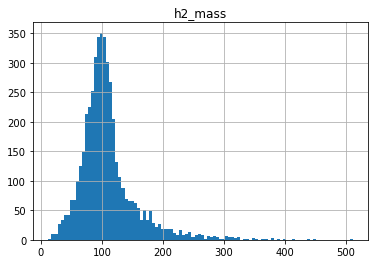

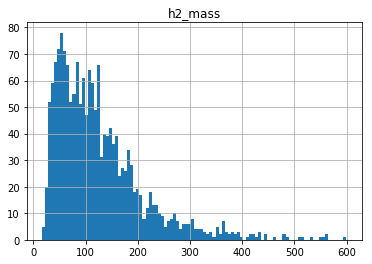

In [23]:
# *** 0. Import Dataset
qcd_raw = pd.read_csv('../higgsReconstruction/EventPlotting/qcd_outputDataForLearning.csv')
hh_raw = pd.read_csv('../higgsReconstruction/EventPlotting/dihiggs_outputDataForLearning.csv')

hh_raw.head()
hh_raw['isSignal'] = 1
print(len(hh_raw), "rows of dihiggs data", hh_raw.columns)
#print( print(hh_raw.loc[[10]]))

qcd_raw.head()
qcd_raw['isSignal'] = 0
#print(len(qcd_raw), "rows of qcd data", qcd_raw.columns)

variableNames = ['hh_mass', 'h1_mass', 'h2_mass']
#variableNames = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)']
#variableNames = ['hh_mass', 'h1_mass', 'h2_mass', 'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)']
print(hh_reducedData.columns, variableNames[0])


hh_reducedData  = hh_raw[variableNames]
qcd_reducedData = qcd_raw[variableNames]
all_reducedData = hh_reducedData.append(qcd_reducedData)

hh_labels  = hh_raw[ ['isSignal'] ]
qcd_labels = qcd_raw[ ['isSignal'] ]
all_labels = hh_labels.append(qcd_labels)

hh_reducedData.hist(column=variableNames[2], bins=100)
qcd_reducedData.hist(column=variableNames[2], bins=100)


In [25]:
# ***1. Split dataset into test + train, make correct input objects
data_train, data_test, label_train, label_test = train_test_split(all_reducedData, all_labels, test_size=0.3)

D_train = xgb.DMatrix(data_train, label=label_train)
D_test = xgb.DMatrix(data_test, label=label_test)

In [26]:
# ***2. Define XGB model and train
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3} 

steps = 20  # The number of training iterations

model = xgb.train(param, D_train, steps)

In [28]:
# ***3. Evaluate model
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(label_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(label_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(label_test, best_preds)))

Precision = 0.7588414484652348
Recall = 0.6840424357406207
Accuracy = 0.803486529318542
